# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP influence the adoption of renewable energy?
- How does austria compare to the european average?


## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) data source.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Exploring the data
### Main data sources
Load all required packages and modules

In [122]:
import glob
import os
import pickle
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [123]:
# ISO codes for European countries
country_codes = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1980, 2020)

We clean the data by:
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [124]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes)) | (df['Entity'].isin(entities))]

    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]


    # Remove 'Code' Column, as it is redundant
    df.drop(columns=['Code'], inplace=True)

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [125]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path_main_data = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path_main_data, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: read_and_clean_csv(file) for file in csv_files}

#### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`
- `energy_consumption_electricity_production:` merged from `modern-renewable-prod`, `modern-renewable-energy-consumption`



In [126]:
def merge_share_dfs(dfs: dict[str: pd.DataFrame], sub_str: str) -> pd.DataFrame:
    relevant_keys = [key for key in dfs.keys() if sub_str in key]
    filtered_dfs = dfs[relevant_keys[0]]
    for key in relevant_keys[1:]:
        filtered_dfs = filtered_dfs.merge(
            dfs[key],
            on=['Entity', 'Year'],
            how='outer'
        )
    return filtered_dfs

def merge_production_consumption(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df1, df2,
                  on=['Entity', 'Year'],
                  how='outer'
                  )
    return df

Let's start off by merging the overall share percentages.

In [127]:
share_energy_long = merge_share_dfs(dataframes, 'share-energy')
share_electricity_long = merge_share_dfs(dataframes, 'share-electricity')
installed_capacity_long = merge_share_dfs(dataframes, 'capacity')

Add new columns based on already existing data.

In [128]:
share_energy_long['Other Renewables (% sub energy)'] = share_energy_long['Renewables (% sub energy)'] - ((share_energy_long['Solar (% sub energy)']) + (share_energy_long['Hydro (% sub energy)']) + (share_energy_long['Wind (% sub energy)']))
share_electricity_long['Other Renewables (% electricity)'] = share_electricity_long['Renewables (% electricity)'] - ((share_electricity_long['Solar (% electricity)']) + (share_electricity_long['Hydro (% electricity)']) + (share_electricity_long['Wind (% electricity)']))

installed_capacity_long['Total Capacity'] = installed_capacity_long['Wind Capacity'].fillna(0) + installed_capacity_long['Geothermal Capacity'].fillna(0) + installed_capacity_long['Solar Capacity'].fillna(0)

Now let's finish by merging the absolute values for production/consumption.

In [129]:
electricity_production_long = dataframes['modern-renewable-prod']
electricity_production_long = electricity_production_long.rename(columns=
                                                       {
                                                           'Electricity from wind (TWh)': 'Electricity production wind (TWh)',
                                                           'Electricity from hydro (TWh)': 'Electricity production hydro (TWh)',
                                                           'Electricity from solar (TWh)': 'Electricity production solar (TWh)',
                                                           'Electricity from other renewables including bioenergy (TWh)': 'Electricity production other renewables including bioenergy (TWh)'
                                                        })

energy_consumption_long = dataframes['modern-renewable-energy-consumption']
energy_consumption_long = energy_consumption_long.rename(columns=
                                                       {
                                                           'Wind Generation - TWh': 'Wind consumption (TWh)',
                                                           'Solar Generation - TWh': 'Solar consumption (TWh)',
                                                           'Geo Biomass Other - TWh': 'Other renewable consumption (TWh)',
                                                           'Hydro Generation - TWh': 'Hydro consumption (TWh)',
                                                        })

energy_consumption_electricity_production_long = merge_production_consumption(energy_consumption_long, electricity_production_long)

#### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat.

In [130]:
share_energy = share_energy_long.set_index(['Entity', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity','Year'])
installed_capacity = installed_capacity_long.set_index(['Entity', 'Year'])
energy_consumption_electricity_production = energy_consumption_electricity_production_long.set_index(['Entity', 'Year'])

#### Check the Data

In [131]:
print("Multi-Index 'share_energy' DataFrame:")
display(share_energy)

print("\nMulti-Index 'share_electricity' DataFrame:")
display(share_electricity)

print("\nMulti-Index 'installed_capacity' DataFrame:")
display(installed_capacity)


print("\nMulti-Index 'energy_production_consumption' DataFrame:")
display(energy_consumption_electricity_production)

Multi-Index 'share_energy' DataFrame:


Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Year                                                    
Austria 1980                25.617                     25.617   
        1981                28.003                     28.003   
        1982                29.015                     29.015   
        1983                28.818                     28.818   
        1984                25.484                     25.484   
...                            ...                        ...   
World   2016                 6.594                     10.239   
        2017                 6.515                     10.618   
        2018                 6.486                     10.978   
        2019                 6.481                     11.437   
        2020                 6.856                     12.553   

              Solar (% sub energy)  Wind (% sub energy)  \
Entity  Year                                              
Austria 1980                 0.000                0.000   
        1981                 0.000                0.000   
        1982                 0.000                0.000   
        1983                 0.000                0.000   
        1984                 0.000                0.000   
...                            ...                  ...   
World   2016                 0.539                1.579   
        2017                 0.715                1.827   
        2018                 0.896                1.972   
        2019                 1.085                2.174   
        2020                 1.365                2.539   

              Other Renewables (% sub energy)  
Entity  Year                                   
Austria 1980                            0.000  
        1981                            0.000  
        1982                            0.000  
        1983                            0.000  
        1984                            0.000  
...                                       ...  
World   2016                            1.527  
        2017                            1.561  
        2018                            1.624  
        2019                            1.697  
        2020                            1.793  

[1277 rows x 5 columns]


Multi-Index 'share_electricity' DataFrame:


Hydro (% electricity)  Renewables (% electricity)  \
Entity  Year                                                      
Austria 1985                 69.103                      69.103   
        1986                 69.209                      72.092   
        1987                 70.050                      71.843   
        1988                 72.014                      74.149   
        1989                 69.922                      72.123   
...                             ...                         ...   
World   2016                 16.531                      24.256   
        2017                 16.277                      25.076   
        2018                 16.129                      25.763   
        2019                 16.048                      26.711   
        2020                 16.516                      28.522   

              Solar (% electricity)  Wind (% electricity)  \
Entity  Year                                                
Austria 1985                  0.000                 0.000   
        1986                  0.000                 0.000   
        1987                  0.000                 0.000   
        1988                  0.000                 0.000   
        1989                  0.000                 0.000   
...                             ...                   ...   
World   2016                  1.358                 3.965   
        2017                  1.782                 4.570   
        2018                  2.196                 4.906   
        2019                  2.642                 5.401   
        2020                  3.197                 6.079   

              Other Renewables (% electricity)  
Entity  Year                                    
Austria 1985                             0.000  
        1986                             2.883  
        1987                             1.793  
        1988                             2.135  
        1989                             2.201  
...                                        ...  
World   2016                             2.402  
        2017                             2.447  
        2018                             2.532  
        2019                             2.620  
        2020                             2.730  

[1173 rows x 5 columns]


Multi-Index 'installed_capacity' DataFrame:


Wind Capacity  Geothermal Capacity  Solar Capacity  \
Entity  Year                                                       
Austria 1996            NaN                  NaN        0.001700   
        1997       0.020000                  NaN        0.002200   
        1998       0.030000                  NaN        0.002900   
        1999       0.042000                  NaN        0.003700   
        2000       0.050000                  NaN        0.005000   
...                     ...                  ...             ...   
World   2016     466.861116            12121.594      291.295309   
        2017     514.374030            12680.665      384.451503   
        2018     563.829025            13244.865      482.915904   
        2019     622.248925            13911.665      580.760214   
        2020     733.276000            14075.000      707.495000   

              Total Capacity  
Entity  Year                  
Austria 1996        0.001700  
        1997        0.022200  
        1998        0.032900  
        1999        0.045700  
        2000        0.055000  
...                      ...  
World   2016    12879.750425  
        2017    13579.490533  
        2018    14291.609929  
        2019    15114.674139  
        2020    15515.771000  

[656 rows x 4 columns]


Multi-Index 'energy_production_consumption' DataFrame:


Wind consumption (TWh)  Solar consumption (TWh)  \
Entity  Year                                                    
Austria 1980                0.000000                 0.000000   
        1981                0.000000                 0.000000   
        1982                0.000000                 0.000000   
        1983                0.000000                 0.000000   
        1984                0.000000                 0.000000   
...                              ...                      ...   
World   2016              962.227395               328.385208   
        2017             1140.310949               446.054164   
        2018             1269.520536               576.951248   
        2019             1418.170046               707.918495   
        2020             1591.213512               855.724690   

              Other renewable consumption (TWh)  Hydro consumption (TWh)  \
Entity  Year                                                               
Austria 1980                           0.000000                29.109900   
        1981                           0.000000                30.847300   
        1982                           0.000000                30.896300   
        1983                           0.000000                30.606300   
        1984                           0.000000                26.849564   
...                                         ...                      ...   
World   2016                         560.681082              4018.671591   
        2017                         593.790980              4066.718275   
        2018                         632.173911              4176.687496   
        2019                         663.134292              4227.883280   
        2020                         700.068651              4296.802045   

              Electricity production wind (TWh)  \
Entity  Year                                      
Austria 1980                               0.00   
        1981                               0.00   
        1982                               0.00   
        1983                               0.00   
        1984                               0.00   
...                                         ...   
World   2016                             959.41   
        2017                            1136.94   
        2018                            1268.43   
        2019                            1420.08   
        2020                            1586.94   

              Electricity production hydro (TWh)  \
Entity  Year                                       
Austria 1980                              29.110   
        1981                              30.847   
        1982                              30.896   
        1983                              30.606   
        1984                              26.850   
...                                          ...   
World   2016                            3999.900   
        2017                            4049.150   
        2018                            4170.020   
        2019                            4219.160   
        2020                            4311.810   

              Electricity production solar (TWh)  \
Entity  Year                                       
Austria 1980                                0.00   
        1981                                0.00   
        1982                                0.00   
        1983                                0.00   
        1984                                0.00   
...                                          ...   
World   2016                              328.48   
        2017                              443.29   
        2018                              567.80   
        2019                              694.50   
        2020                              834.63   

              Electricity production other renewables including bioenergy (TWh)  
Entity  Year                                                                   

### Secondary Data Sources
In order to make reasonable assumptions, we include some additional external data sources for:
- GDP per capita (USD)
- Electricity Prices (EUR/kWh)



In [132]:
folder_path_secondary_data = os.path.join('..', 'secondary-data')

Let's start with the GDP per capita.

In [133]:
def melt_year_columns(df: pd.DataFrame) -> pd.DataFrame:
    df_melted = df.melt(
        id_vars=["Entity", "Code"],  # Keep these columns as they are
        var_name="Year",                   # New column name for years
        value_name="GDP per capita (USD)"                 # New column name for values
    )

    # Convert the 'Year' column to numeric, ignoring non-numeric entries
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

    # Drop rows where 'Year' or 'Value' is NaN
    df_melted = df_melted.dropna(subset=["Year", "GDP per capita (USD)"]).reset_index(drop=True)

    df_melted["Year"] = df_melted["Year"].astype(int)

    return df_melted

In [134]:
# GDP per capita (USD)
gdp_per_capita_csv_file = os.path.join(folder_path_secondary_data, 'gdp_per_capita.csv')
gdp_per_capita_original = pd.read_csv(gdp_per_capita_csv_file)
gdp_per_capita_long = melt_year_columns(gdp_per_capita_original)
gdp_per_capita_long = clean_df(gdp_per_capita_long)

Now we take a look at the electricity prices

In [135]:
# Mapping of country names to their codes
country_name_to_code = {
    'Austria': 'AT', 'Belgium': 'BE', 'Bulgaria': 'BG', 'Croatia': 'HR',
    'Cyprus': 'CY', 'Czechia': 'CZ', 'Denmark': 'DK', 'Estonia': 'EE',
    'Finland': 'FI', 'France': 'FR', 'Germany': 'DE', 'Greece': 'EL',
    'Hungary': 'HU', 'Iceland': 'IS', 'Ireland': 'IE', 'Italy': 'IT',
    'Latvia': 'LV', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Netherlands': 'NL',
    'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Romania': 'RO',
    'Slovakia': 'SK', 'Slovenia': 'SI', 'Spain': 'ES', 'Sweden': 'SE',
    'Switzerland': 'CH', 'United Kingdom': 'UK'
}

country_code_to_name = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'HR': 'Croatia',
    'CY': 'Cyprus', 'CZ': 'Czechia', 'DK': 'Denmark', 'EE': 'Estonia',
    'FI': 'Finland', 'FR': 'France', 'DE': 'Germany', 'EL': 'Greece',
    'HU': 'Hungary', 'IS': 'Iceland', 'IE': 'Ireland', 'IT': 'Italy',
    'LV': 'Latvia', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'NL': 'Netherlands',
    'NO': 'Norway', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania',
    'SK': 'Slovakia', 'SI': 'Slovenia', 'ES': 'Spain', 'SE': 'Sweden',
    'CH': 'Switzerland', 'UK': 'United Kingdom'
}


time_window_electricity_price = (2007, 2025)

# Filter for the selected countries
selected_country_codes = set(country_name_to_code.values())

In [136]:
def clean_numeric_values(val):
    """
    Function ensures numeric conversion for time columns
    :param val:
    :return:
    """
    if isinstance(val, str):
        return re.sub(r'[^\d.-]', '', val.strip())  # Remove non-numeric characters and strip spaces
    return val

def clean_electricity_price_df(df: pd.DataFrame) -> pd.DataFrame:
    # Strip whitespace from column names
    df.columns = [col.strip() for col in df.columns]

    # Extract the first column name dynamically
    first_column_name = df.columns[0]

    # Extract the country code from the first column
    df['Entity'] = df[first_column_name].str.split(',').str[-1].str.strip()
    df.drop(columns=[first_column_name], inplace=True)

    # Identify time-based columns (e.g., 2007-S1)
    time_columns = [col for col in df.columns if re.match(r'\d{4}-S\d', col)]

    # Clean time columns and convert to numeric
    df[time_columns] = df[time_columns].applymap(clean_numeric_values).apply(pd.to_numeric, errors='coerce')

    # Deduplicate by country code
    df = df.drop_duplicates(subset=['Entity'])

    filtered_data = df[df['Entity'].isin(selected_country_codes)]

    return filtered_data

def convert_electricity_price_to_annual_means(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate annual means (average of S1-S4 per year)
    annual_means = {}
    for year in range(time_window_electricity_price[0], time_window_electricity_price[1]):
        semesters = [f"{year}-S{semester}" for semester in range(1, 5)]
        available_semesters = [sem for sem in semesters if sem in df.columns]
        if available_semesters:
            annual_means[year] = df[available_semesters].mean(axis=1, skipna=True)

    # Create a DataFrame for annual means
    annual_means_df = pd.DataFrame(annual_means)
    annual_means_df.index = df['Entity']

    return annual_means_df

def read_clean_convert_electricity_prices(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df = clean_electricity_price_df(df)
    df = convert_electricity_price_to_annual_means(df)
    return df


In [137]:
household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_204.tsv')
non_household_electricity_csv_file = os.path.join(folder_path_secondary_data, 'estat_nrg_pc_205.tsv')

household_electricity = read_clean_convert_electricity_prices(household_electricity_csv_file)
non_household_electricity = read_clean_convert_electricity_prices(non_household_electricity_csv_file)

# Align both DataFrames by their indices (countries) and columns (years)
combined_data = (household_electricity + non_household_electricity) / 2

# Map country codes to their full names for better visualization
combined_data.index = combined_data.index.map(
    {v: k for k, v in country_name_to_code.items()}
)
display(combined_data)

C:\Users\elias\AppData\Local\Temp\ipykernel_24448\1354932856.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[time_columns] = df[time_columns].applymap(clean_numeric_values).apply(pd.to_numeric, errors='coerce')
C:\Users\elias\AppData\Local\Temp\ipykernel_24448\1354932856.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[time_columns] = df[time_columns].applymap(clean_numeric_values).apply(pd.to_numeric, errors='coerce')


,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Entity,,,,,,,,,,,,,,,,,,
Austria,0.20080,0.20190,0.20950,0.21435,0.22055,0.22375,0.23435,0.23260,0.24060,0.24660,0.23825,0.23655,0.24395,0.25390,0.27185,0.26150,0.30215,0.3011
Belgium,0.18670,0.23195,0.21220,0.22005,0.23675,0.23815,0.23715,0.22010,0.23885,0.29595,0.32440,0.31040,0.30870,0.29680,0.30355,0.41095,0.43350,0.3715
Bulgaria,0.07210,0.07695,0.08230,0.08225,0.08435,0.09010,0.09030,0.08695,0.09575,0.09560,0.09730,0.09950,0.09985,0.10190,0.10745,0.11285,0.11690,0.1193
Cyprus,0.15540,0.18315,0.14105,0.19300,0.22265,0.28400,0.26055,0.23165,0.18845,0.15665,0.18670,0.21645,0.23420,0.20420,0.22880,0.30505,0.37720,0.3432
Czechia,0.15955,0.19075,0.19860,0.20330,0.21635,0.21670,0.21560,0.18380,0.18435,0.18825,0.19415,0.21035,0.23260,0.23735,0.24175,0.19320,0.37045,0.3974
Germany,0.22990,0.24140,0.25310,0.26585,0.27755,0.28855,0.31725,0.32290,0.32095,0.32800,0.33615,0.33320,0.33485,0.33865,0.35575,0.36905,0.44970,0.4423
Denmark,0.26760,0.29950,0.29190,0.29915,0.32490,0.32930,0.32605,0.33195,0.33315,0.33415,0.32675,0.33785,0.32015,0.30795,0.34105,0.54465,0.39435,0.3972
Estonia,0.07990,0.08475,0.09385,0.10045,0.10275,0.11320,0.13910,0.13500,0.13335,0.12545,0.12845,0.14250,0.14600,0.14000,0.17035,0.23665,0.25190,0.2546
Greece,0.09310,0.09205,0.09455,0.10400,0.10950,0.12555,0.15355,0.17250,0.18075,0.17195,0.16830,0.17020,0.16095,0.17020,0.18715,0.23425,0.24865,0.2435


#### Multi-Index

In [138]:
gdp_per_capita = gdp_per_capita_long.set_index(['Entity', 'Year']).sort_index()

#### Check the data
GDP Data.

In [139]:
display(gdp_per_capita)
display(gdp_per_capita.describe())

GDP per capita (USD)
Entity  Year                      
Austria 1980          10869.546494
        1981           9385.249064
        1982           9410.347257
        1983           9537.407420
        1984           8991.065040
...                            ...
World   2016          10264.928662
        2017          10798.152765
        2018          11347.335847
        2019          11397.086000
        2020          10918.722834

[1189 rows x 1 columns]

,GDP per capita (USD)
count,1189.000000
mean,24795.316029
std,21083.584520
min,1102.103785
25%,9926.129971
50%,19050.585921
75%,33368.142415
max,123514.196686


### Noticing Trends
Now let's create some plots in order to better observe certain trends

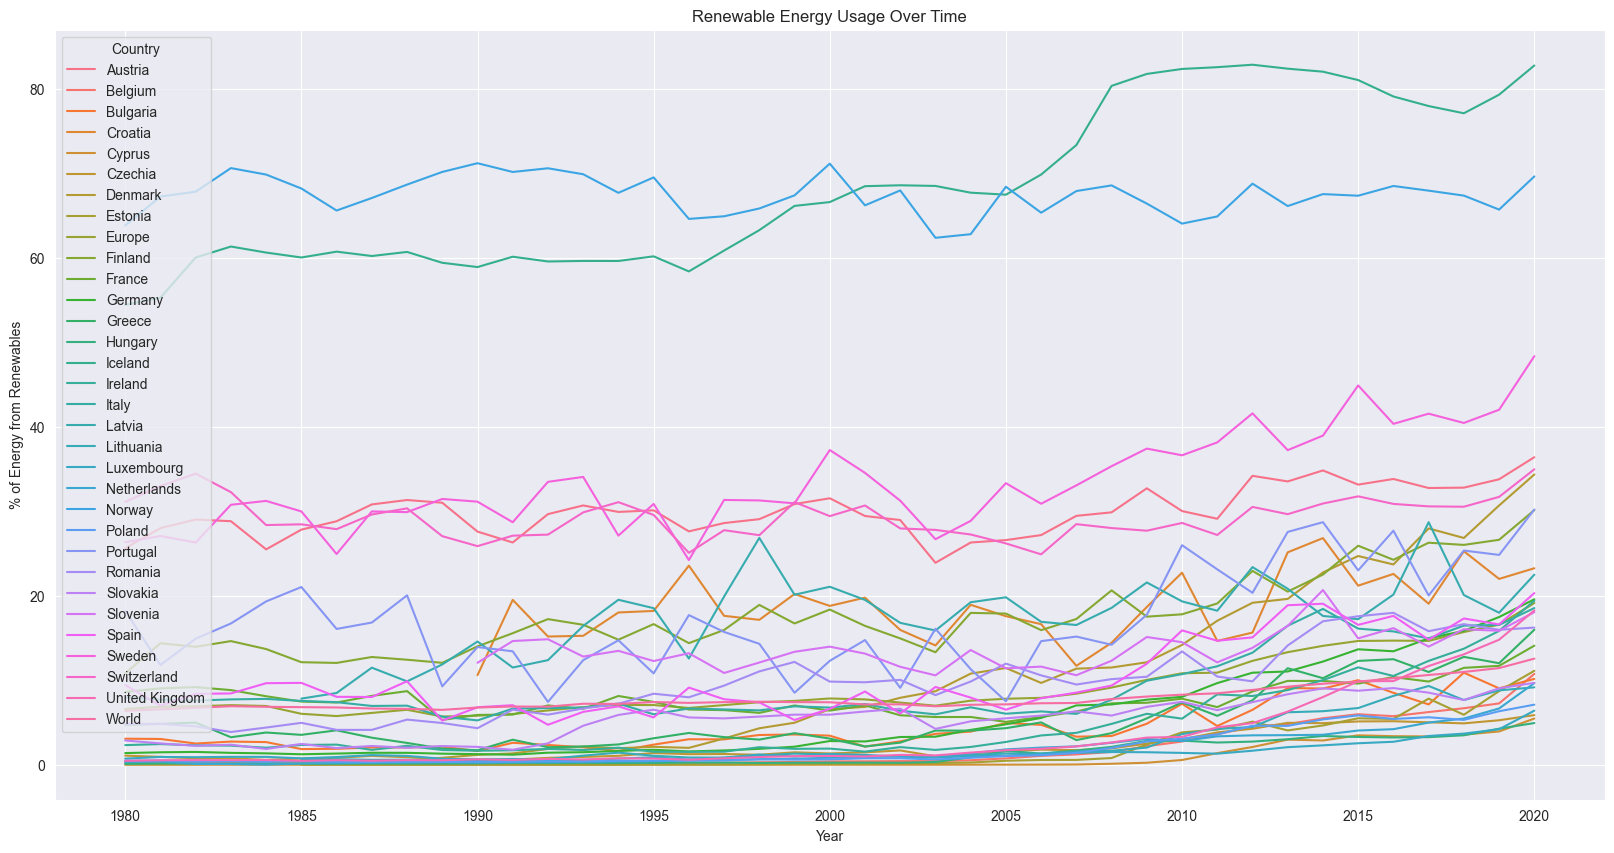

In [140]:
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Plot renewables over time for selected countries
plt.figure(figsize=(20, 10))
sns.lineplot(data=data_filtered, x='Year', y='Renewables (% sub energy)', hue='Entity')
plt.title('Renewable Energy Usage Over Time')
plt.ylabel('% of Energy from Renewables')
plt.xlabel('Year')
plt.legend(title='Country')
plt.grid(True)
plt.show()

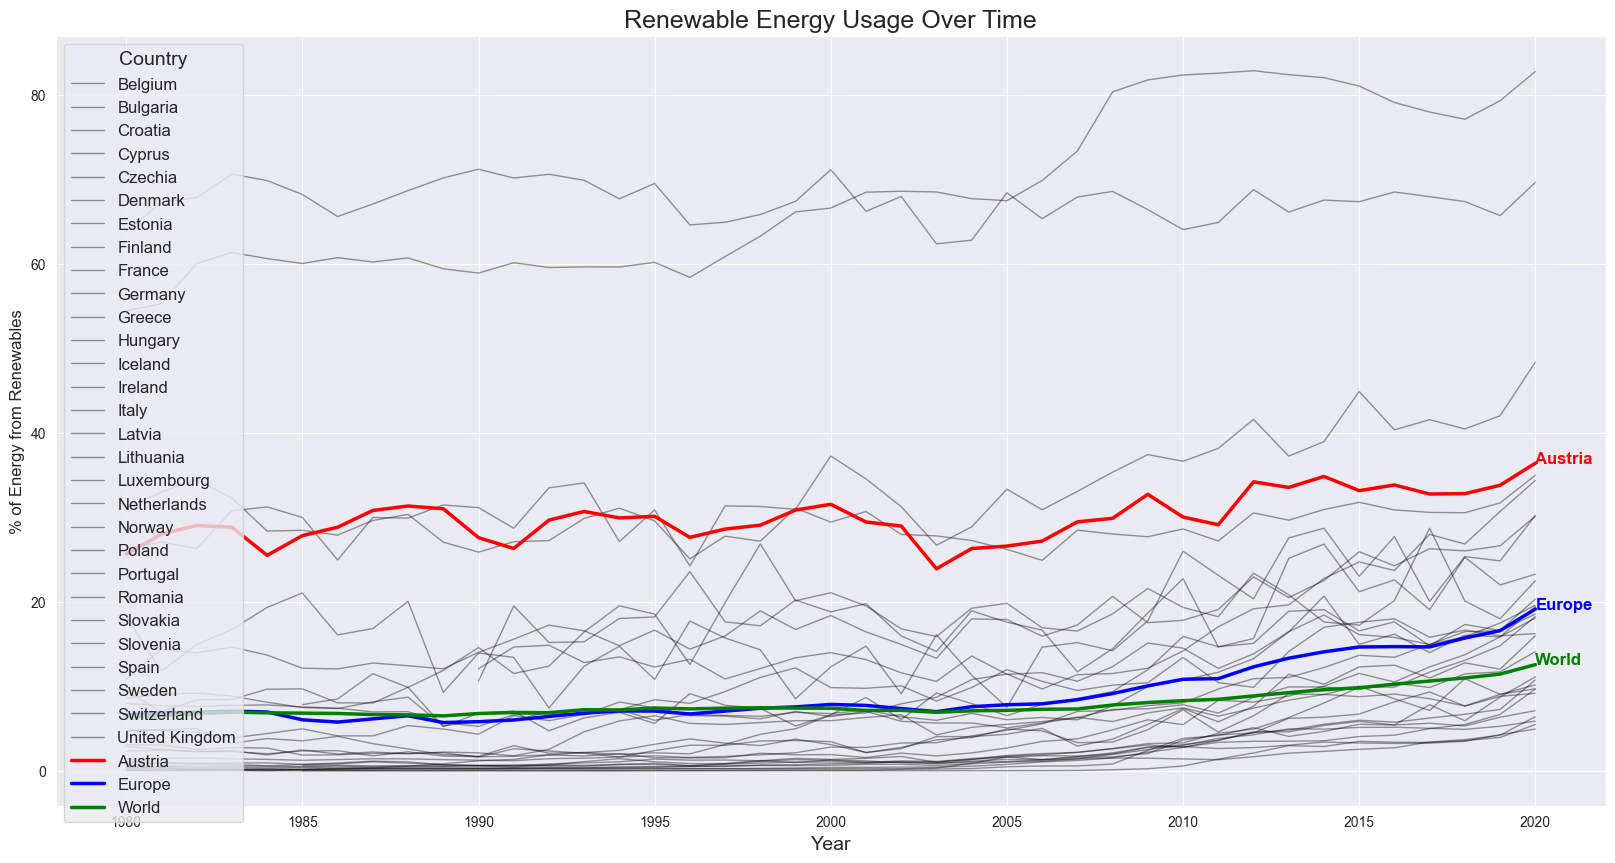

In [141]:
# Filter data for specific countries
countries = ['Austria', 'Belgium', 'Czechia', 'Europe', 'France', 'Germany', 'Spain', 'Norway', 'Romania', 'United Kingdom', 'World']
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'black' for country in data_filtered['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

# Plot
plt.figure(figsize=(20, 10))

# Plot all countries with lighter lines
sns.lineplot(
    data=data_filtered[~data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, alpha=0.4, linewidth=1
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=data_filtered[data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, linewidth=2.5
)

# Add titles and labels
plt.title('Renewable Energy Usage Over Time', fontsize=18)
plt.ylabel('% of Energy from Renewables', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Country', fontsize=12, title_fontsize=14)
plt.grid(True)

# Highlight lines with direct annotations
for country in standout_countries:
    country_data = data_filtered[data_filtered['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Renewables (% sub energy)'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.show()

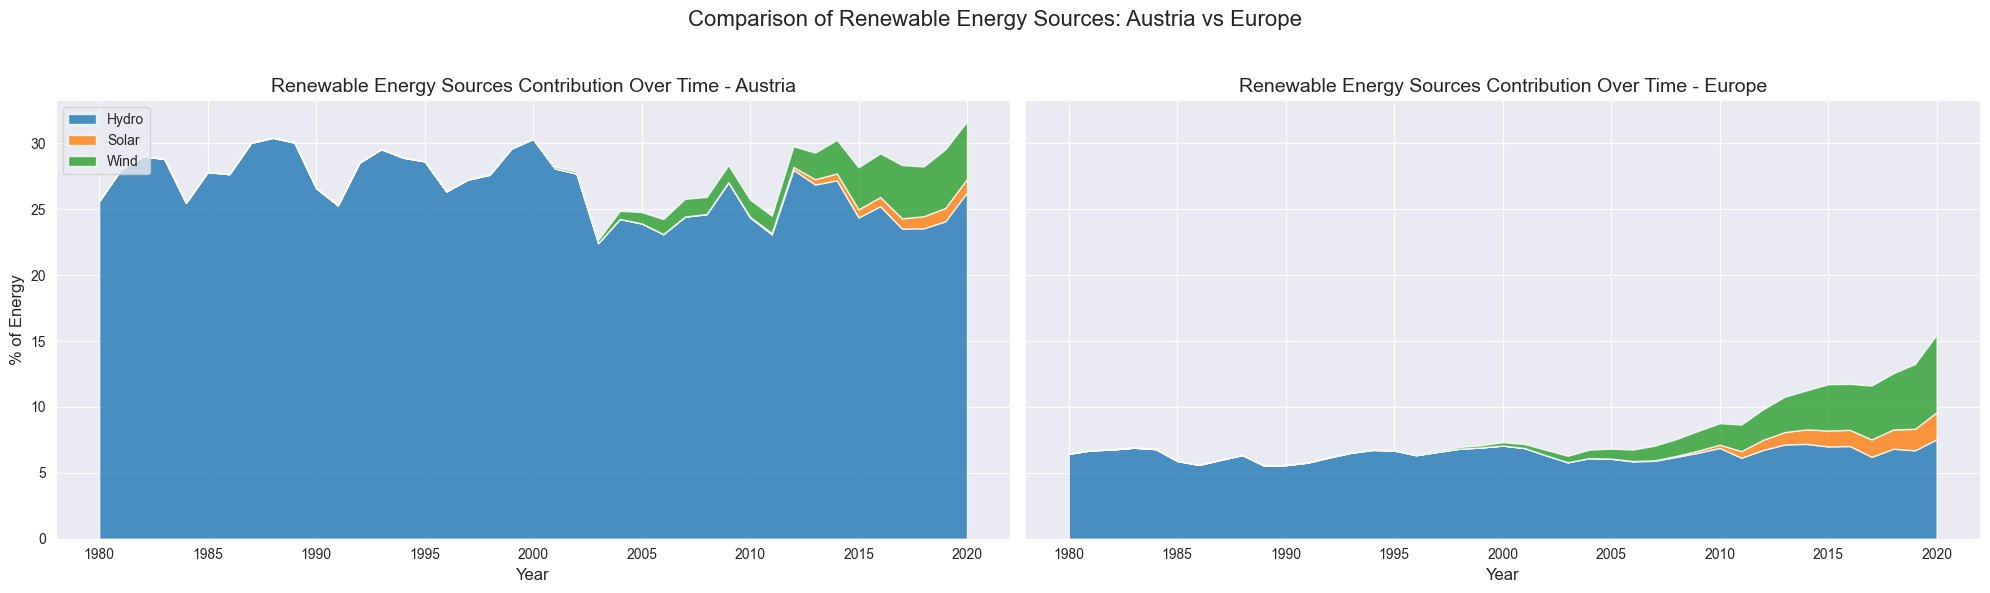

In [142]:
# Select data for Austria
country_austria = 'Austria'
data_austria = share_energy.loc[country_austria].reset_index()

# Select data for Europe
country_europe = 'Europe'
data_europe = share_energy.loc[country_europe].reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for Austria
axes[0].stackplot(
    data_austria['Year'],
    data_austria['Hydro (% sub energy)'],
    data_austria['Solar (% sub energy)'],
    data_austria['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[0].set_title(f'Renewable Energy Sources Contribution Over Time - {country_austria}', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('% of Energy', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot for Europe
axes[1].stackplot(
    data_europe['Year'],
    data_europe['Hydro (% sub energy)'],
    data_europe['Solar (% sub energy)'],
    data_europe['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[1].set_title(f'Renewable Energy Sources Contribution Over Time - {country_europe}', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.suptitle('Comparison of Renewable Energy Sources: Austria vs Europe', fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Even though we only have specific data for Hydro, Solar and Wing generation, there other renewable ways of generating energy. To show how much data we are missing on other renewable energy types, we plotted the most recent (2020) energy usage.

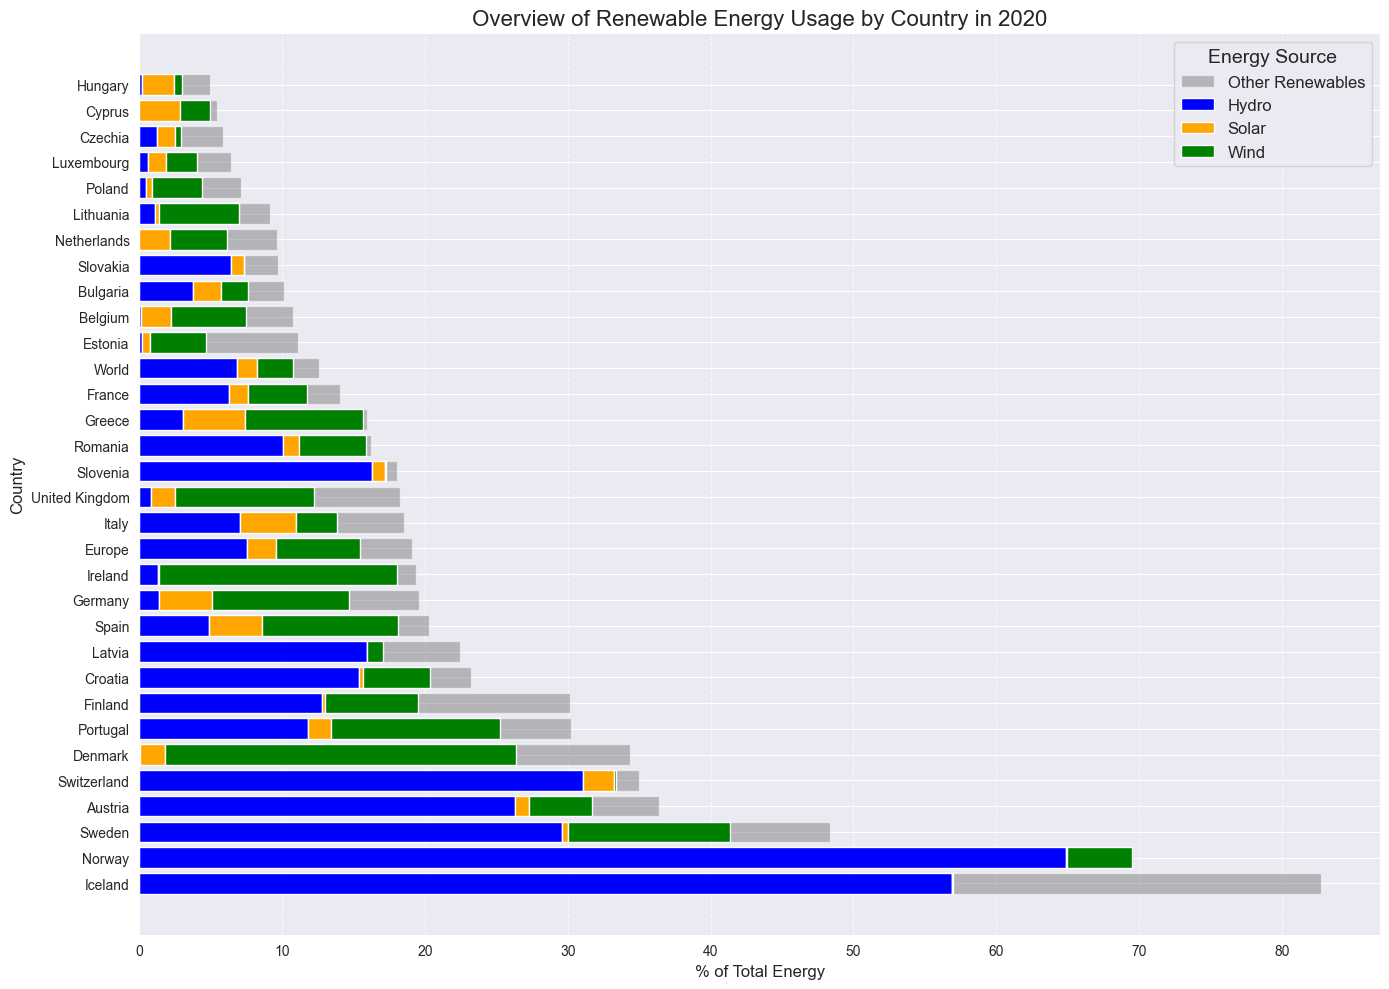

In [143]:
# Filter the data for the year 2020
data_2020 = share_energy.xs(key=2020, level='Year')

# Sort by total renewables for better visualization
data_2020 = data_2020.sort_values(by='Renewables (% sub energy)', ascending=False)

# Create a stacked bar plot
plt.figure(figsize=(14, 10))

# Plot the total renewable energy as a separate bar beforehand
# This makes it show up as the other types of renewable energy that we are missing (e.g. not in hydro, wind, solar)
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Renewables (% sub energy)'], label='Other Renewables', color='gray', alpha=0.5)

# Plot the stacked bars for Hydro, Solar, and Wind
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Solar (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'],
    label='Solar',
    color='orange'
)
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Wind (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'] + data_2020['Solar (% sub energy)'],
    label='Wind',
    color='green'
)

# Add labels and title
plt.title('Overview of Renewable Energy Usage by Country in 2020', fontsize=16)
plt.xlabel('% of Total Energy', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Energy Source', fontsize=12, title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## Which types of renewable energy have been predominantly adopted?
Plot how the percentage of renewable energy from different sources (Hydro, Solar, Wind, and Other Renewables) has changed globally, to get an overall view.

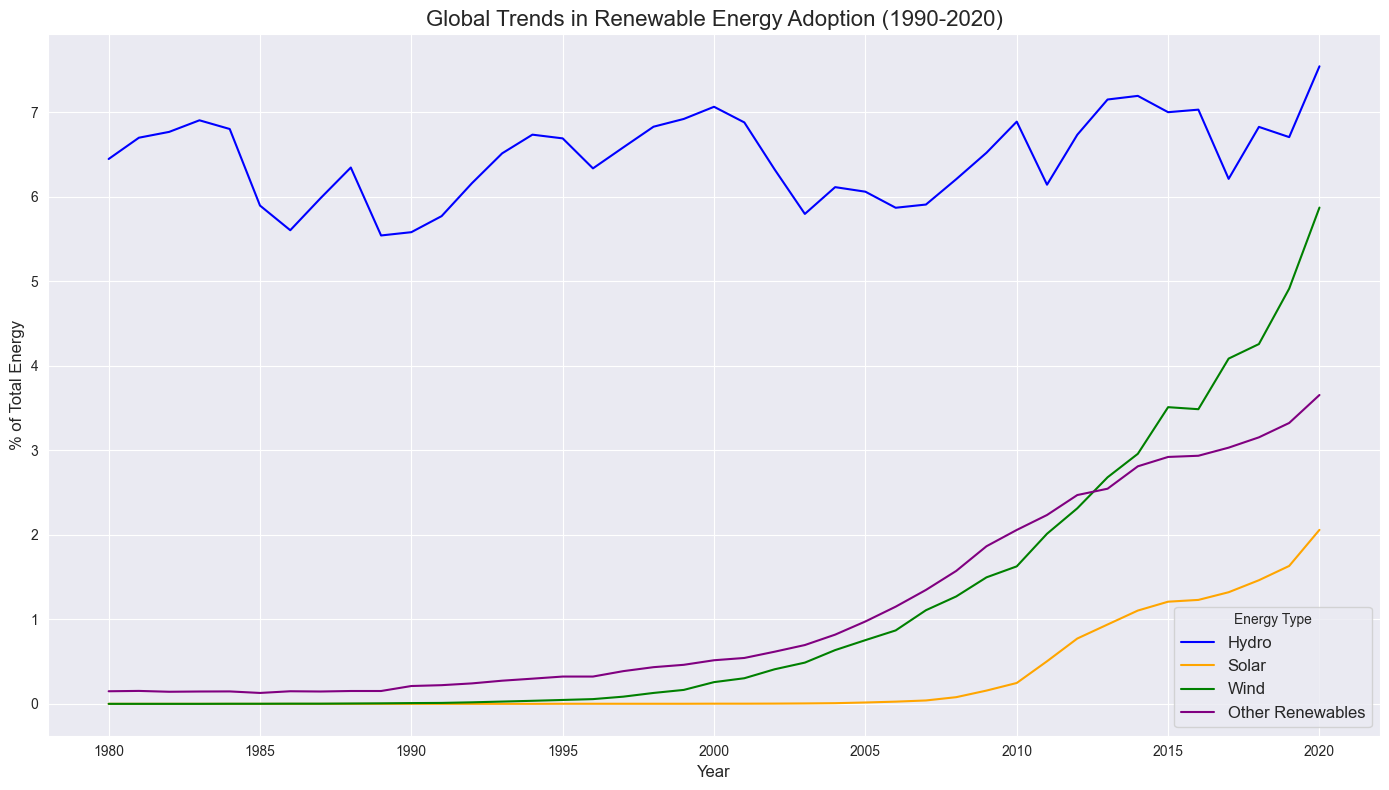

In [144]:
# Filter for global data (use 'World' as the entity)
share_energy_europe = share_energy.xs(key='Europe', level='Entity')

# TODO replace with seaborn
# Plot trends in renewable energy types (Hydro, Solar, Wind, Other Renewables) globally
plt.figure(figsize=(14, 8))
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Solar (% sub energy)'], label='Solar', color='orange')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Wind (% sub energy)'], label='Wind', color='green')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Other Renewables (% sub energy)'], label='Other Renewables', color='purple')

plt.title('Global Trends in Renewable Energy Adoption (1990-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('% of Total Energy', fontsize=12)
plt.legend(title='Energy Type', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Determine the dominant renewable energy source by calculating the mean share for each source over time

In [145]:
# Calculate the average percentage of each renewable energy type globally over time
mean_renewables = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].mean()

# Sort to identify the most dominant energy type
mean_renewables_sorted = mean_renewables.sort_values(ascending=False)

# Print the result
print(f"Most Predominantly Adopted Renewable Energy Types (Mean over Time):\n{mean_renewables_sorted}")

Most Predominantly Adopted Renewable Energy Types (Mean over Time):
Hydro (% sub energy)               6.471561
Wind (% sub energy)                1.119829
Other Renewables (% sub energy)    1.119195
Solar (% sub energy)               0.312780
dtype: float64


Another interesting analysis is to see which year had the highest adoption of each energy source.

In [146]:
# Find the year with the highest percentage for each renewable energy type globally
max_renewables_year = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].idxmax()

# Print the results
print(f"Year with the highest adoption of each renewable energy type:\n{max_renewables_year}")

Year with the highest adoption of each renewable energy type:
Hydro (% sub energy)               2020
Solar (% sub energy)               2020
Wind (% sub energy)                2020
Other Renewables (% sub energy)    2020
dtype: int64


#### Renewable Energy capacity

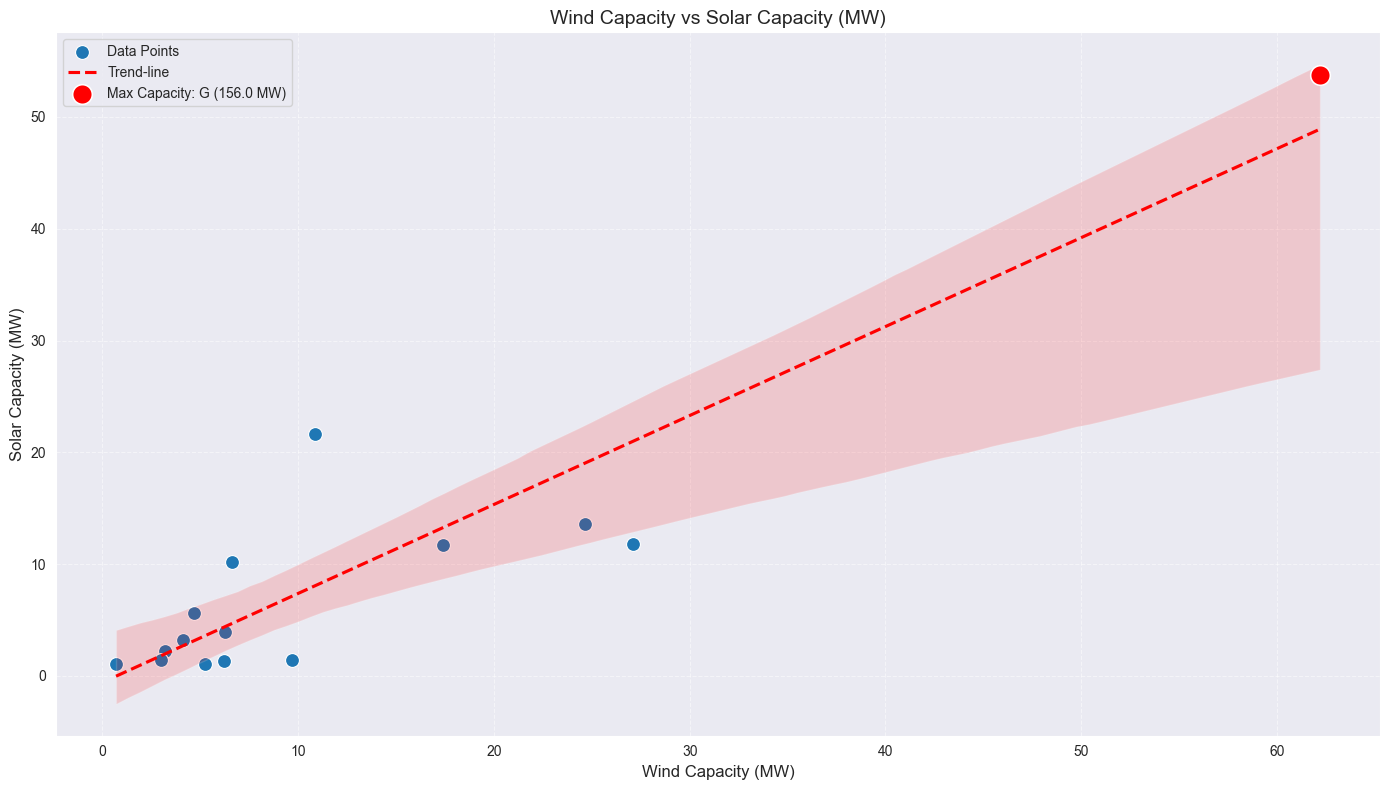

In [147]:
installed_capacity_2020 = installed_capacity.xs(key=2020, level='Year')
# Exclude non-country entities:
installed_capacity_2020_countries_only = installed_capacity_2020[~installed_capacity_2020.index.get_level_values("Entity").isin(["World", "Europe"])].copy()
installed_capacity_2020_countries_only["Solar+Wind Capacity"] = (
    installed_capacity_2020_countries_only["Wind Capacity"].fillna(0) +
    installed_capacity_2020_countries_only["Solar Capacity"].fillna(0)
)

# Identify the entity with the maximum total capacity
max_entity = installed_capacity_2020_countries_only["Solar+Wind Capacity"].idxmax()
max_capacity = installed_capacity_2020_countries_only.loc[max_entity]

installed_capacity_2020_countries_only_reset = installed_capacity_2020_countries_only.reset_index()

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    s=100,
    label="Data Points",
)

sns.regplot(
    data=installed_capacity_2020_countries_only_reset,
    x="Wind Capacity",
    y="Solar Capacity",
    scatter=False,
    color="red",
    label="Trend-line",
    line_kws={"linestyle": "--"},
)

# Highlight the point with the highest capacity
sns.scatterplot(
    x=[max_capacity["Wind Capacity"]],
    y=[max_capacity["Solar Capacity"]],
    color="red",
    s=200,
    label=f"Max Capacity: {max_entity[0]} ({max_capacity['Total Capacity']:.1f} MW)",
)

plt.title("Wind Capacity vs Solar Capacity (MW)", fontsize=14)
plt.xlabel("Wind Capacity (MW)", fontsize=12)
plt.ylabel("Solar Capacity (MW)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Interesting statistics and relations
## Relation between energy and electricity
Merge the share percentages into a single frame for easier plotting and data analysis


In [148]:
share_energy_electricity = pd.merge(
    share_energy,
    share_electricity,
    left_index=True,
    right_index=True,
    how='inner'
)

Additionally merge all our data into a single **mega-frame** for easier plotting/training

In [149]:
def construct_mega_frame(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    mega_df = dfs[0]

    for df in dfs[1:]:
        mega_df = pd.merge(
            mega_df,
            df,
            left_index=True,
            right_index=True,
            how='inner'
        )

    return mega_df


In [150]:
dfs = [share_energy_electricity, gdp_per_capita, energy_consumption_electricity_production]
mega_df = construct_mega_frame(dfs)
display(mega_df)

Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Year                                                    
Austria 1985                27.820                     27.820   
        1986                27.659                     28.812   
        1987                30.033                     30.802   
        1988                30.420                     31.323   
        1989                30.056                     31.002   
...                            ...                        ...   
World   2016                 6.594                     10.239   
        2017                 6.515                     10.618   
        2018                 6.486                     10.978   
        2019                 6.481                     11.437   
        2020                 6.856                     12.553   

              Solar (% sub energy)  Wind (% sub energy)  \
Entity  Year                                              
Austria 1985                 0.000                0.000   
        1986                 0.000                0.000   
        1987                 0.000                0.000   
        1988                 0.000                0.000   
        1989                 0.000                0.000   
...                            ...                  ...   
World   2016                 0.539                1.579   
        2017                 0.715                1.827   
        2018                 0.896                1.972   
        2019                 1.085                2.174   
        2020                 1.365                2.539   

              Other Renewables (% sub energy)  Hydro (% electricity)  \
Entity  Year                                                           
Austria 1985                            0.000                 69.103   
        1986                            1.153                 69.209   
        1987                            0.769                 70.050   
        1988                            0.903                 72.014   
        1989                            0.946                 69.922   
...                                       ...                    ...   
World   2016                            1.527                 16.531   
        2017                            1.561                 16.277   
        2018                            1.624                 16.129   
        2019                            1.697                 16.048   
        2020                            1.793                 16.516   

              Renewables (% electricity)  Solar (% electricity)  \
Entity  Year                                                      
Austria 1985                      69.103                  0.000   
        1986                      72.092                  0.000   
        1987                      71.843                  0.000   
        1988                      74.149                  0.000   
        1989                      72.123                  0.000   
...                                  ...                    ...   
World   2016                      24.256                  1.358   
        2017                      25.076                  1.782   
        2018                      25.763                  2.196   
        2019                      26.711                  2.642   
        2020                      28.522                  3.197   

              Wind (% electricity)  Other Renewables (% electricity)  \
Entity  Year                                                           
Austria 1985                 0.000                             0.000   
        1986                 0.000                             2.883   
        1987                 0.000                             1.793   
        1988                 0.000                             2.135   
        1989                 0.000                             2.201   
...                            ...                               ...   
World   2016   

### Visualizations
First we look at the energy-electricity gap (The difference between energy and electricity adoption). Let's plot the countries with the largest gap.

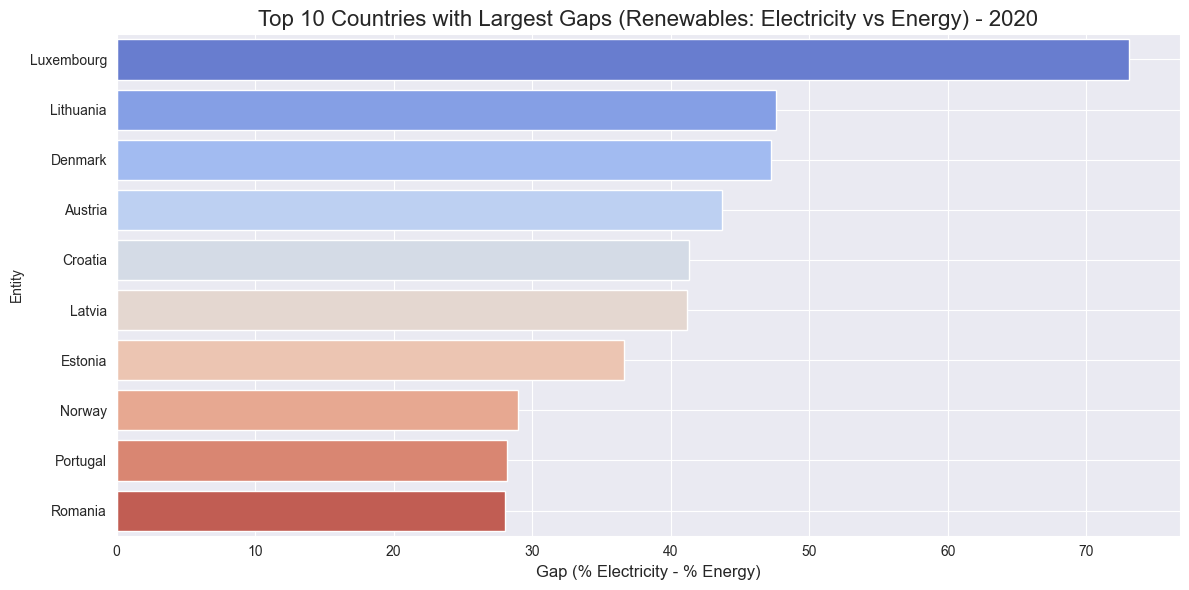

In [151]:
# Filter for the year 2020
data_2020 = share_energy_electricity.xs(key=2020, level='Year').copy()  # Use `.copy()` to avoid the warning

# Calculate the gap between Renewable Electricity and Renewable Energy
data_2020.loc[:, 'Gap'] = data_2020['Renewables (% electricity)'] - data_2020['Renewables (% sub energy)']

# Sort by the largest gap
largest_gaps = data_2020[['Gap']].sort_values(by='Gap', ascending=False).reset_index()

# Bar plot for the largest gaps in 2020
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Entity', palette='coolwarm', hue='Entity', dodge=False, legend=False)
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's compare Austria to the rest of europe.

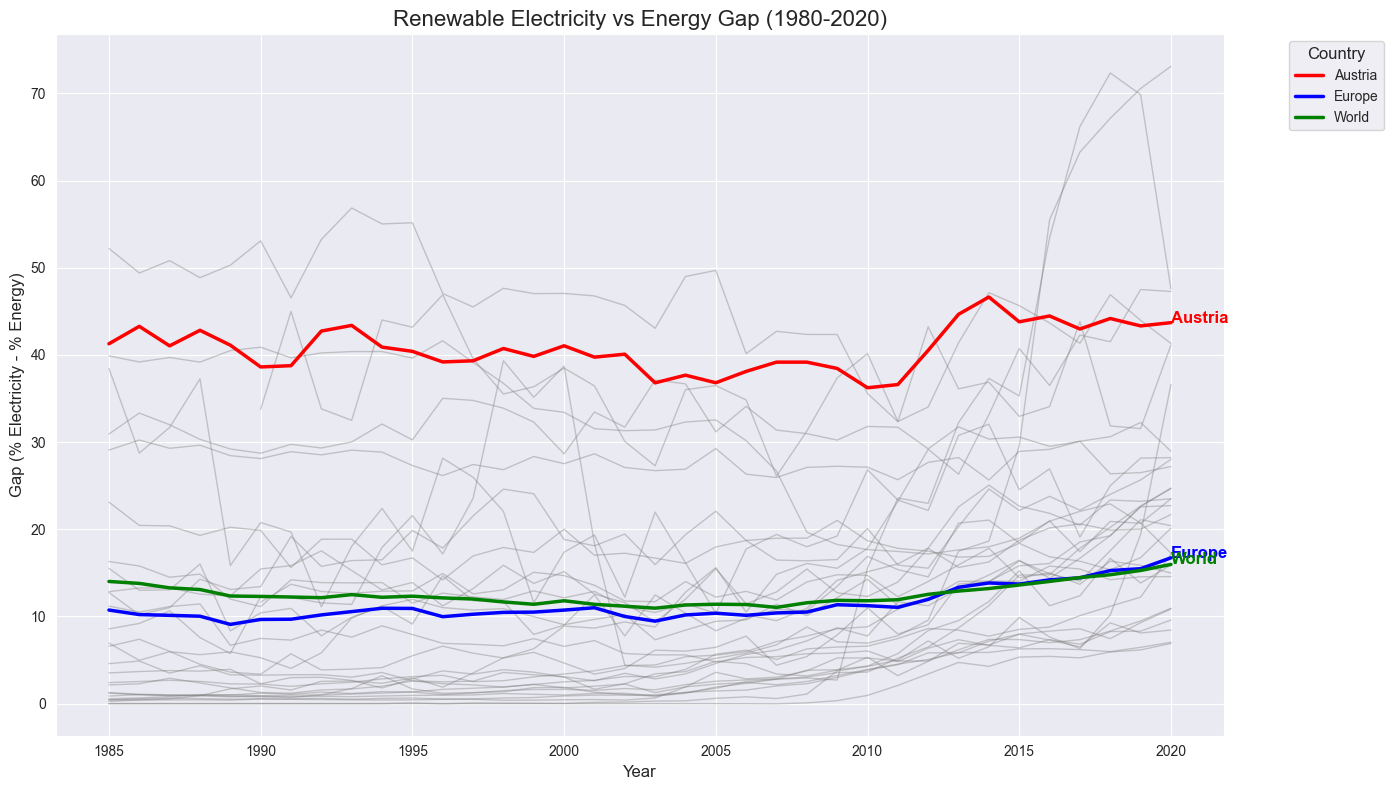

In [152]:
# Filter for the last 10 years (2011–2020)
energy_electricity_long = share_energy_electricity.copy()

# Calculate the gap for each country and year
energy_electricity_long.loc[:, 'Gap'] = energy_electricity_long['Renewables (% electricity)'] - energy_electricity_long['Renewables (% sub energy)']

# Reset index for plotting
gap_over_time = energy_electricity_long.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'gray' for country in gap_over_time['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

plt.figure(figsize=(14, 8))

# Plot all countries with lighter lines
sns.lineplot(
    data=gap_over_time[~gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, alpha=0.4, linewidth=1, legend=False
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=gap_over_time[gap_over_time['Entity'].isin(standout_countries)],
    x='Year', y='Gap', hue='Entity', palette=palette, linewidth=2.5
)

# Add labels and title
plt.title(f'Renewable Electricity vs Energy Gap ({time_window[0]}-{time_window[1]})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.legend(title='Country', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)

# Highlight standout countries with direct annotations
for country in standout_countries:
    country_data = gap_over_time[gap_over_time['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Gap'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.tight_layout()
plt.show()


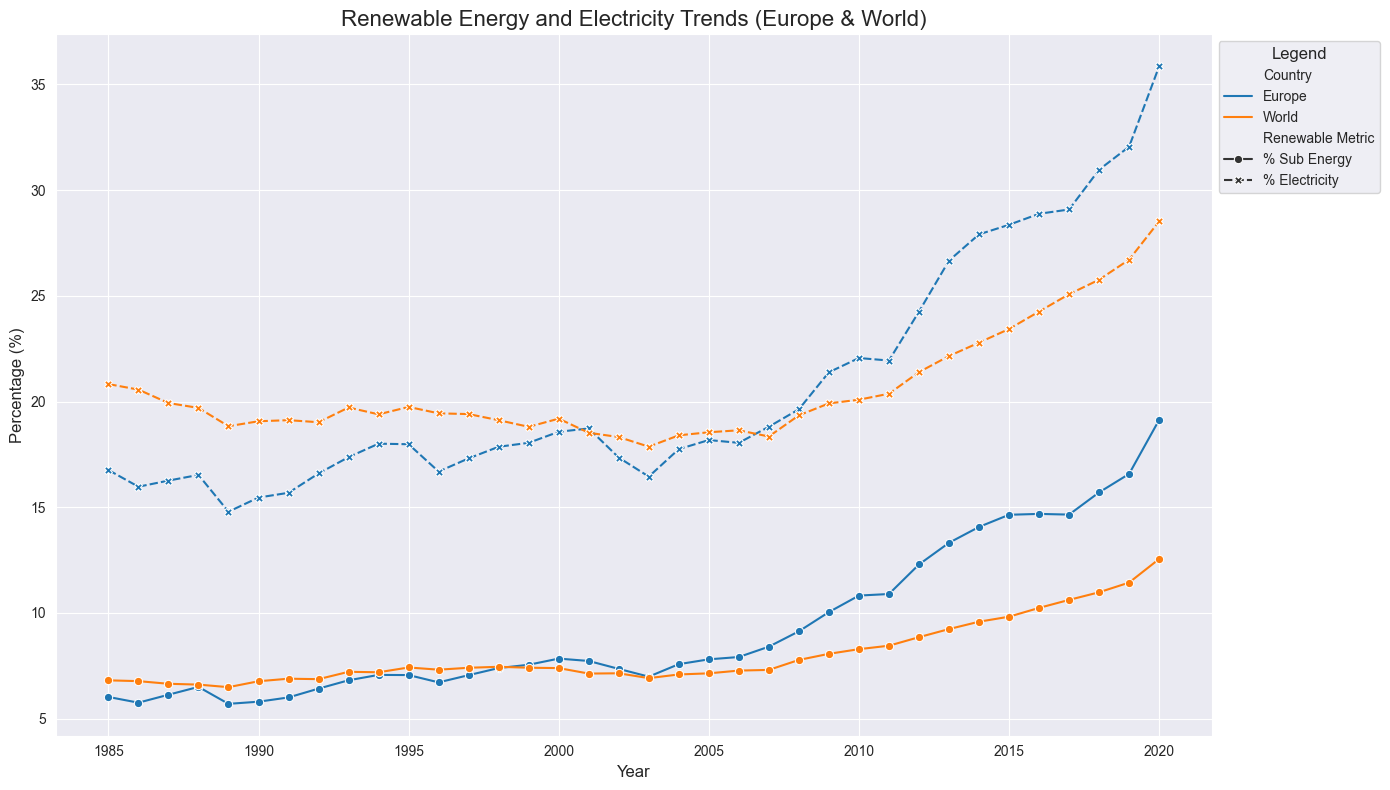

In [153]:
# Define europe_world (if not already defined)
europe_world = share_energy_electricity.loc[
    share_energy_electricity.index.get_level_values('Entity').isin(['Europe', 'World'])
].reset_index()

europe_world.rename(columns={'Entity': 'Country'}, inplace=True)

# Reshape the data to combine 'Renewables (% sub energy)' and 'Renewables (% electricity)' into one column
europe_world_melted = europe_world.melt(
    id_vars=['Year', 'Country'],
    value_vars=['Renewables (% sub energy)', 'Renewables (% electricity)'],
    var_name='Renewable Metric',
    value_name='Percentage'
)

# Rename metrics for better readability
europe_world_melted['Renewable Metric'] = europe_world_melted['Renewable Metric'].replace({
    'Renewables (% sub energy)': '% Sub Energy',
    'Renewables (% electricity)': '% Electricity'
})

# Create a line plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=europe_world_melted,
    x='Year',
    y='Percentage',
    hue='Country',
    style='Renewable Metric',  # Different styles for sub energy vs electricity
    markers=True,
    dashes=True,
    palette='tab10'
)

# Add plot titles and labels
plt.title('Renewable Energy and Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Customize the legend for clarity
plt.legend(title='Legend', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Dependency on weather data

Fetching weather data for Austria...
Fetching weather data for Belgium...
Fetching weather data for Bulgaria...
Fetching weather data for Croatia...
Fetching weather data for Cyprus...
Fetching weather data for Czechia...
Fetching weather data for Denmark...
Fetching weather data for Estonia...
Fetching weather data for Finland...
Fetching weather data for France...
Fetching weather data for Germany...
Fetching weather data for Greece...
Fetching weather data for Hungary...
Fetching weather data for Iceland...
Fetching weather data for Ireland...
Fetching weather data for Italy...
Fetching weather data for Latvia...
Fetching weather data for Lithuania...
Fetching weather data for Luxembourg...
Fetching weather data for Malta...
Fetching weather data for Netherlands...
Fetching weather data for Norway...
Fetching weather data for Poland...
Fetching weather data for Portugal...
Fetching weather data for Romania...
Fetching weather data for Slovakia...
Fetching weather data for Slovenia..

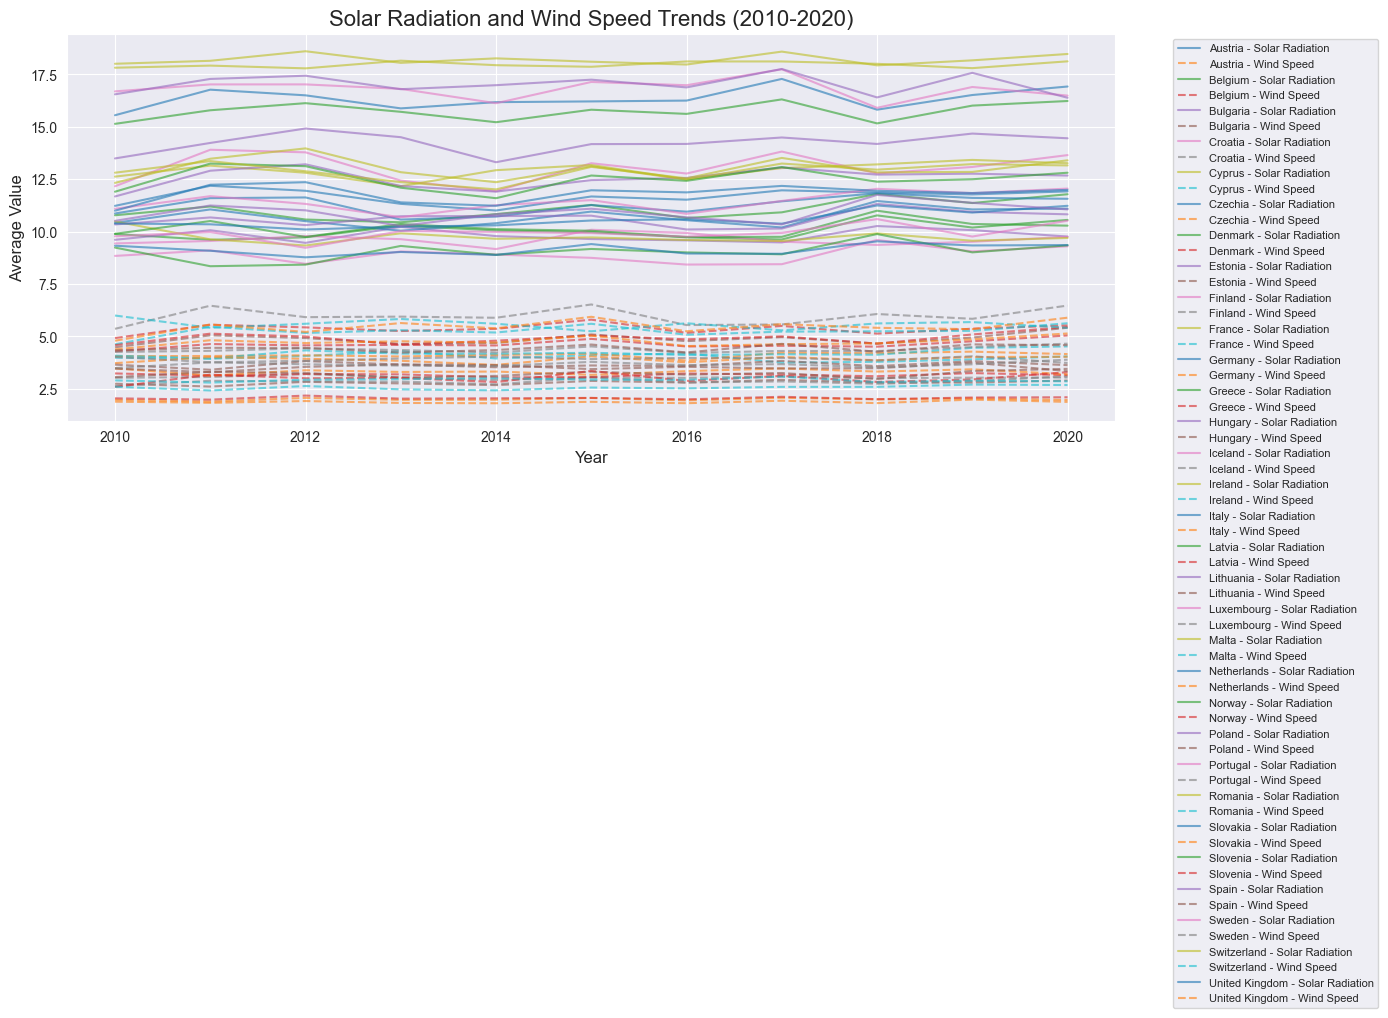

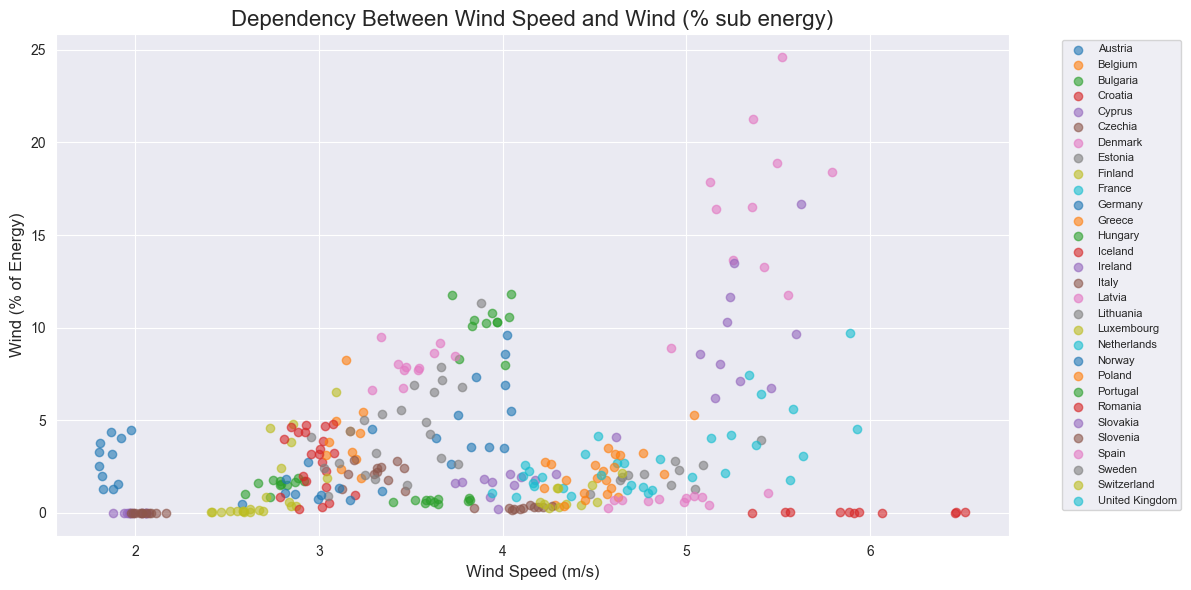

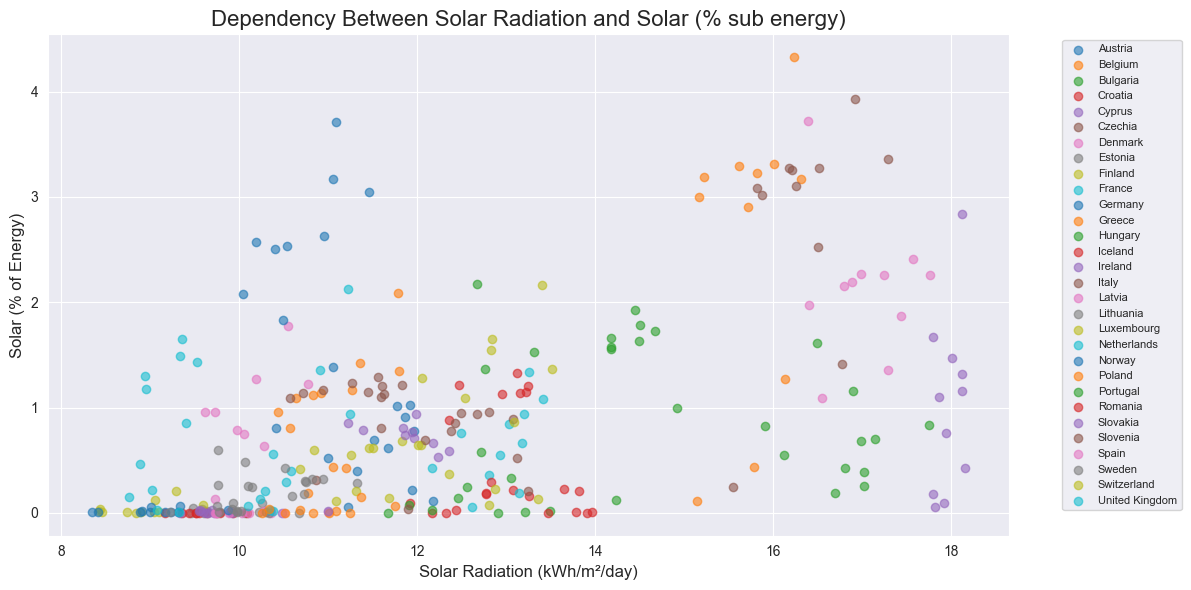

In [154]:
import requests

# List of European countries
european_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland', 'United Kingdom'
]

# Function to fetch weather data
def fetch_weather_data(lat, lon, start_year, end_year):
    """Fetch daily solar radiation and wind speed data from NASA POWER API."""
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "ALLSKY_SFC_SW_DWN,WS10M",
        "community": "AG",
        "longitude": lon,
        "latitude": lat,
        "start": f"{start_year}0101",
        "end": f"{end_year}1231",
        "format": "JSON",
        "header": "true",
        "time-standard": "UTC"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json()

# Dictionary of country coordinates (add exact latitude and longitude for each country)
country_coordinates = {
    'Austria': (47.5162, 14.5501),
    'Belgium': (50.8503, 4.3517),
    'Bulgaria': (42.7339, 25.4858),
    'Croatia': (45.1, 15.2),
    'Cyprus': (35.1264, 33.4299),
    'Czechia': (49.8175, 15.473),
    'Denmark': (56.2639, 9.5018),
    'Estonia': (58.5953, 25.0136),
    'Finland': (61.9241, 25.7482),
    'France': (46.6034, 1.8883),
    'Germany': (51.1657, 10.4515),
    'Greece': (39.0742, 21.8243),
    'Hungary': (47.1625, 19.5033),
    'Iceland': (64.9631, -19.0208),
    'Ireland': (53.4129, -8.2439),
    'Italy': (41.8719, 12.5674),
    'Latvia': (56.8796, 24.6032),
    'Lithuania': (55.1694, 23.8813),
    'Luxembourg': (49.8153, 6.1296),
    'Malta': (35.9375, 14.3754),
    'Netherlands': (52.1326, 5.2913),
    'Norway': (60.4720, 8.4689),
    'Poland': (51.9194, 19.1451),
    'Portugal': (39.3999, -8.2245),
    'Romania': (45.9432, 24.9668),
    'Slovakia': (48.6690, 19.6990),
    'Slovenia': (46.1512, 14.9955),
    'Spain': (40.4637, -3.7492),
    'Sweden': (60.1282, 18.6435),
    'Switzerland': (46.8182, 8.2275),
    'United Kingdom': (55.3781, -3.4360)
}

# Fetch weather data for each country
time_window_weather = (2010, 2020)
weather_data = {}

file_path ='api_data.pkl'
cached_api_data = {}
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:  # Use "rb" mode to read in binary format
        cached_api_data = pickle.load(file)

for country, (lat, lon) in country_coordinates.items():
    print(f"Fetching weather data for {country}...")
    try:
        key = (lat, lon)
        if key not in cached_api_data:
            cached_api_data[key] = fetch_weather_data(key[0], key[1], time_window_weather[0], time_window_weather[1])

        data = cached_api_data[key]
        daily_data = data['properties']['parameter']
        df = pd.DataFrame({
            'Date': pd.to_datetime(list(daily_data['ALLSKY_SFC_SW_DWN'].keys())),
            'Solar Radiation': list(daily_data['ALLSKY_SFC_SW_DWN'].values()),
            'Wind Speed': list(daily_data['WS10M'].values())
        })
        df['Year'] = df['Date'].dt.year
        yearly_data = df.groupby('Year')[['Solar Radiation', 'Wind Speed']].mean().reset_index()
        weather_data[country] = yearly_data
    except Exception as e:
        print(f"Failed to fetch weather data for {country}: {e}")

# save cached weather data
with open(file_path, 'wb') as file:
    pickle.dump(cached_api_data, file)

# Extract power data from `share_energy`
power_data = pd.DataFrame()
for country in european_countries:
    if country in share_energy.index.get_level_values('Entity'):
        country_power_data = share_energy.loc[country].reset_index()
        country_power_data['Country'] = country
        power_data = pd.concat([power_data, country_power_data])

# Combine weather and power data
combined_data = pd.DataFrame()
for country, weather_df in weather_data.items():
    power_df = power_data[power_data['Country'] == country]
    combined = weather_df.merge(power_df, on='Year', how='inner')
    combined['Country'] = country
    combined_data = pd.concat([combined_data, combined])

# First Plot: Solar Radiation and Wind Speed Trends
plt.figure(figsize=(14, 8))
for country, data in weather_data.items():
    plt.plot(data['Year'], data['Solar Radiation'], label=f"{country} - Solar Radiation", linestyle='-', alpha=0.6)
    plt.plot(data['Year'], data['Wind Speed'], label=f"{country} - Wind Speed", linestyle='--', alpha=0.6)

plt.title('Solar Radiation and Wind Speed Trends (2010-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot 1: Wind Speed vs Wind (% sub energy)
plt.figure(figsize=(12, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.scatter(country_data['Wind Speed'], country_data['Wind (% sub energy)'], label=country, alpha=0.6)

plt.title('Dependency Between Wind Speed and Wind (% sub energy)', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Wind (% of Energy)', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot 2: Solar Radiation vs Solar (% sub energy)
plt.figure(figsize=(12, 6))
for country in combined_data['Country'].unique():
    country_data = combined_data[combined_data['Country'] == country]
    plt.scatter(country_data['Solar Radiation'], country_data['Solar (% sub energy)'], label=country, alpha=0.6)

plt.title('Dependency Between Solar Radiation and Solar (% sub energy)', fontsize=16)
plt.xlabel('Solar Radiation (kWh/m²/day)', fontsize=12)
plt.ylabel('Solar (% of Energy)', fontsize=12)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Calculate European averages for each year

In [155]:
european_averages = combined_data.groupby('Year').agg({
    'Wind Speed': 'mean',
    'Wind (% sub energy)': 'mean',
    'Solar Radiation': 'mean',
    'Solar (% sub energy)': 'mean'
}).reset_index()

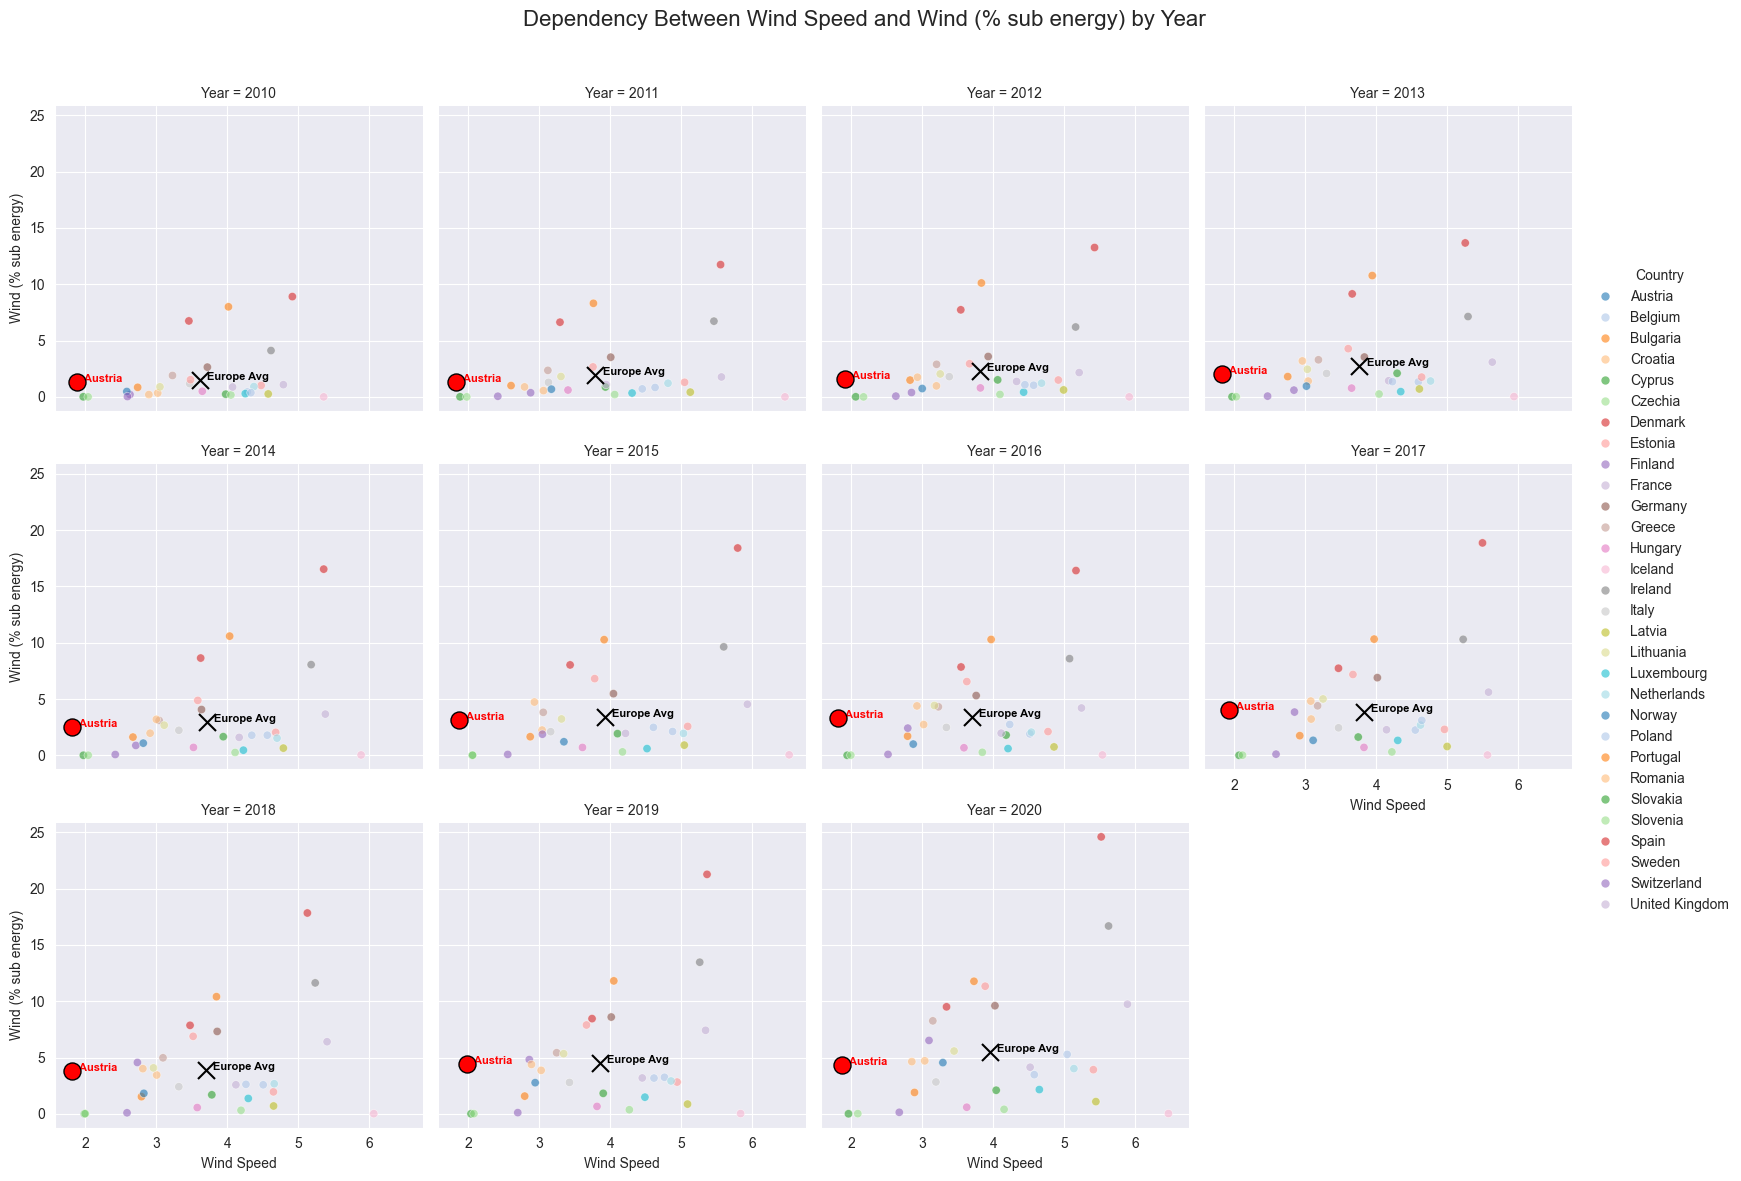

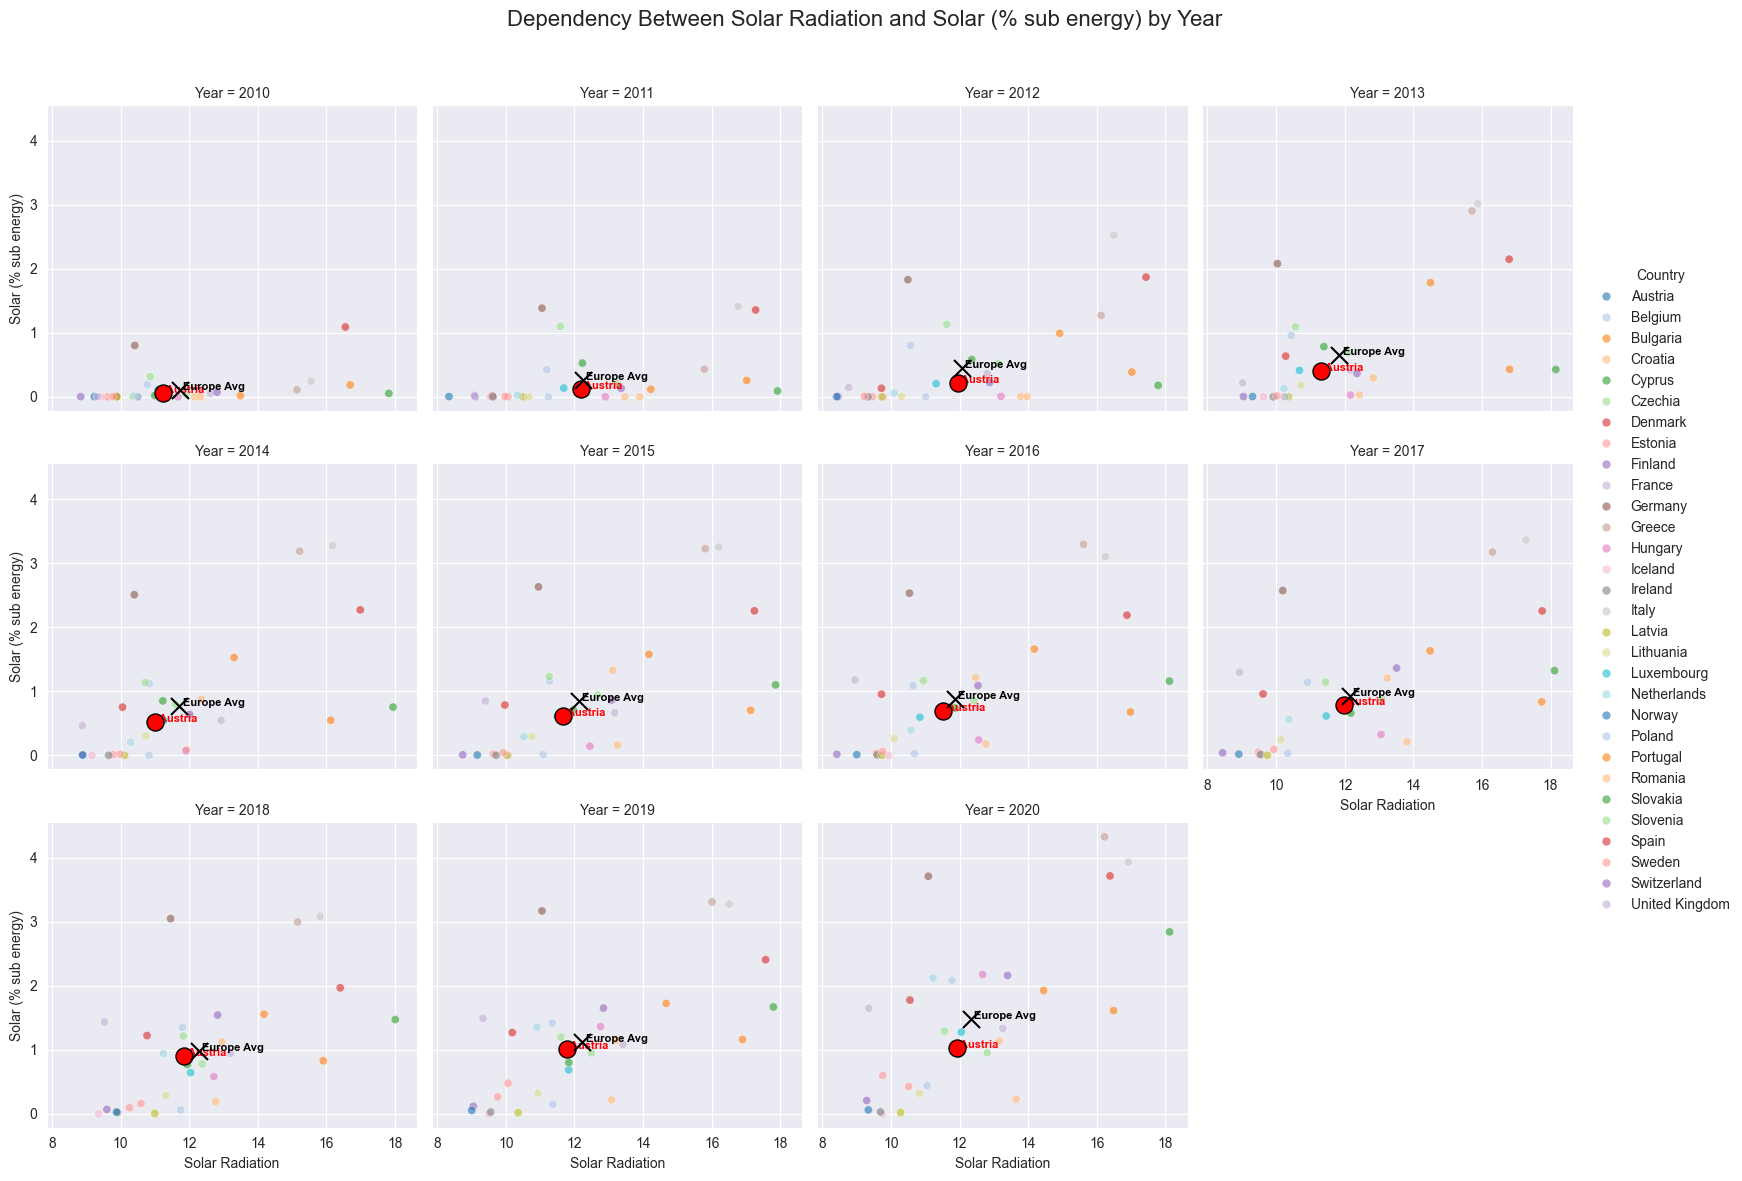

In [156]:
# Scatter plot for wind speed vs. wind contribution
g = sns.relplot(
    data=combined_data,
    x='Wind Speed',
    y='Wind (% sub energy)',
    col='Year',
    kind='scatter',
    col_wrap=4,
    height=4,
    alpha=0.6,
    hue='Country',
    palette='tab20',
    legend='brief'  # Automatic legend for countries
)

# Highlight Austria and add European averages with labels
for ax, year in zip(g.axes.flat, combined_data['Year'].unique()):
    # Highlight Austria
    austria_data = combined_data[(combined_data['Country'] == 'Austria') & (combined_data['Year'] == year)]
    if not austria_data.empty:
        ax.scatter(
            austria_data['Wind Speed'], austria_data['Wind (% sub energy)'],
            color='red', s=150, edgecolor='black', zorder=5  # Highlight Austria
        )
        # Add label for Austria
        ax.text(
            austria_data['Wind Speed'].values[0] + 0.1,
            austria_data['Wind (% sub energy)'].values[0],
            'Austria', color='red', fontsize=8, weight='bold'
        )
    # Add European average
    avg_data = european_averages[european_averages['Year'] == year]
    if not avg_data.empty:
        ax.scatter(
            avg_data['Wind Speed'], avg_data['Wind (% sub energy)'],
            color='black', s=150, marker='x', zorder=6  # Highlight European average
        )
        # Add label for European average
        ax.text(
            avg_data['Wind Speed'].values[0] + 0.1,
            avg_data['Wind (% sub energy)'].values[0],
            'Europe Avg', color='black', fontsize=8, weight='bold'
        )

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Dependency Between Wind Speed and Wind (% sub energy) by Year', fontsize=16)
plt.show()

# Scatter plot for solar radiation vs. solar contribution
g = sns.relplot(
    data=combined_data,
    x='Solar Radiation',
    y='Solar (% sub energy)',
    col='Year',
    kind='scatter',
    col_wrap=4,
    height=4,
    alpha=0.6,
    hue='Country',
    palette='tab20',
    legend='brief'  # Automatic legend for countries
)

# Highlight Austria and add European averages with labels
for ax, year in zip(g.axes.flat, combined_data['Year'].unique()):
    # Highlight Austria
    austria_data = combined_data[(combined_data['Country'] == 'Austria') & (combined_data['Year'] == year)]
    if not austria_data.empty:
        ax.scatter(
            austria_data['Solar Radiation'], austria_data['Solar (% sub energy)'],
            color='red', s=150, edgecolor='black', zorder=5  # Highlight Austria
        )
        # Add label for Austria
        ax.text(
            austria_data['Solar Radiation'].values[0] + 0.1,
            austria_data['Solar (% sub energy)'].values[0],
            'Austria', color='red', fontsize=8, weight='bold'
        )
    # Add European average
    avg_data = european_averages[european_averages['Year'] == year]
    if not avg_data.empty:
        ax.scatter(
            avg_data['Solar Radiation'], avg_data['Solar (% sub energy)'],
            color='black', s=150, marker='x', zorder=6  # Highlight European average
        )
        # Add label for European average
        ax.text(
            avg_data['Solar Radiation'].values[0] + 0.1,
            avg_data['Solar (% sub energy)'].values[0],
            'Europe Avg', color='black', fontsize=8, weight='bold'
        )

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Dependency Between Solar Radiation and Solar (% sub energy) by Year', fontsize=16)
plt.show()

# Predictions for the future

In [157]:
# TODO: Train a model and crate a graph for how the future could look like?

data_filtered = share_energy.reset_index()

X = data_filtered[['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']]
y = data_filtered['Renewables (% sub energy)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", (-grid_search.best_score_) ** 0.5)

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_pred)
print(f"Test Set RMSE with Best Model: {test_rmse}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

## Predictions using random Random Forest

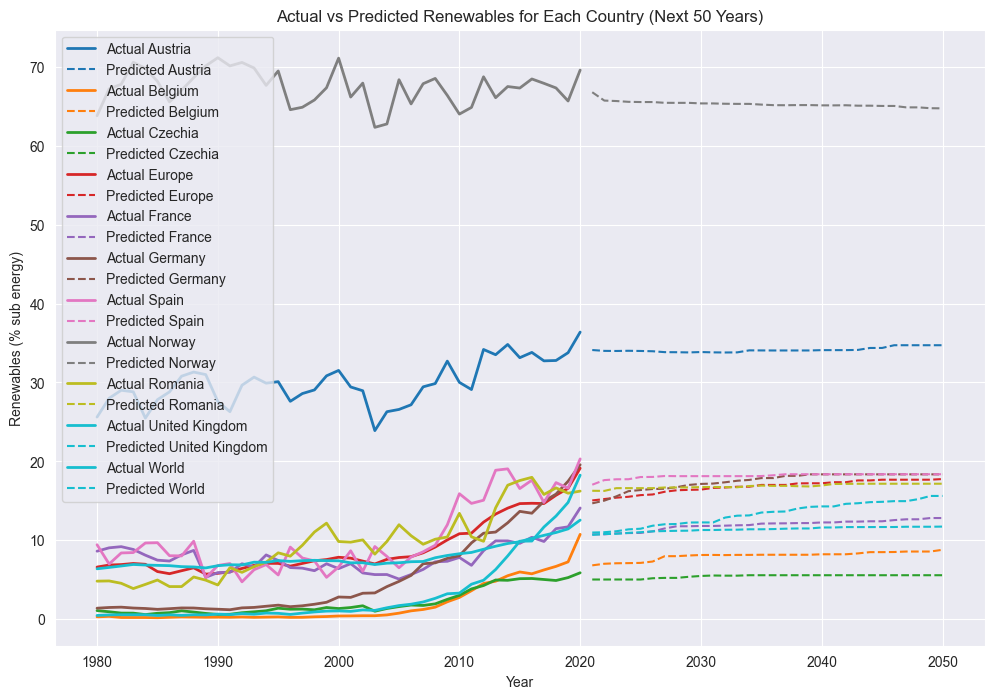

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

df = data_filtered.sort_values(by=['Year'])

X_columns = ['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']
scaler = StandardScaler()

rfr_model = grid_search.best_estimator_


plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_df = df[df['Entity'] == country]
    if country_df.empty:
        print(f"Skipping country {country} due to no data available.")
        continue

    X = country_df[X_columns]
    y = country_df['Renewables (% sub energy)']

    X_scaled = scaler.fit_transform(X)

    rfr_model.fit(X_scaled, y)

    last_known_year = country_df['Year'].max()
    future_years = np.arange(last_known_year + 1, last_known_year + 31)

    future_data = []

    for feature in X_columns[1:]:
        lr = LinearRegression()
        lr.fit(country_df[['Year']], country_df[feature])

        future_years_df = pd.DataFrame(future_years, columns=['Year'])
        future_feature_values = lr.predict(future_years_df)
        future_data.append(future_feature_values.flatten())

    future_data = np.column_stack([future_years] + future_data)

    future_df = pd.DataFrame(future_data, columns=X_columns)
    future_data_scaled = scaler.transform(future_df)
    future_predictions = rfr_model.predict(future_data_scaled)

    line = plt.plot(country_df['Year'], y, label=f'Actual {country}', linewidth=2, color = colors[i])
    prediction = plt.plot(future_years, future_predictions, label=f'Predicted {country}', linestyle='--', color = colors[i])

plt.xlabel('Year')
plt.ylabel('Renewables (% sub energy)')
plt.title('Actual vs Predicted Renewables for Each Country (Next 50 Years)')
plt.legend()
plt.grid(True)
plt.show()

Here we predicted the development of renewable energy adoption until 2050. To do this, we used a simple model in order to interpolate the values of the different features such as previous Hydro, Wind or Solar adoption.